#### Import Dataset 

In [ ]:
import numpy as np 
import torch 
from torchvision import datasets, transforms 


trainset = datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
valset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
testset = datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Split & Prepare Dataset 

In [ ]:
val_ratio = 0.1 
train_data, val_data = torch.utils.data.random_split(trainset, (int(len(trainset)*(1-val_ratio)), int(len(trainset)*val_ratio)))


#### Build the 4-Layer CNN 
consists of 4 convolutional layers and 1 fully connected layer at the end. Each convolutional layer (64 filters of 3x3 kernel size with stride 1 and zero-padding 1) is followed by batch normalisation, relu activation and max pooling (2x2 kernel size with stride 2) 

In [ ]:
import torch.nn as nn 

class CNN(torch.nn.Module): 
  def __init__(self): 
    super(CNN, self).__init__() 
    self.first_layer = self.layer(1, 64)
    self.second_layer = self.layer(64, 64)
    self.third_layer = self.layer(64, 64) 
    self.fourth_layer = self.layer(64, 64) 
    self.output_layer = nn.Linear(64, 10, device = "cuda:0")  # fully - connected layer 
                                        # out features = 10 classes 

  # in_channel = 1 as images are black and white 
  def layer(self, in_channels, out_channels): 
    device = "cuda:0"
    cnn_layer = nn.Sequential(
        nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'zeros', device = device), 
        nn.BatchNorm2d(64, device = device ), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) 
    )
    return cnn_layer 

  def forward(self, x): 
    first_layer = self.first_layer(x)
    second_layer = self.second_layer(first_layer) 
    third_layer = self.third_layer(second_layer) 
    fourth_layer = self.fourth_layer(third_layer)
    flattened = torch.flatten(fourth_layer, 1)
    out = self.output_layer(flattened)
    return out 

In [ ]:
def train_function(num_epochs, train_data): 
  model = CNN()
  optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
  loss_function = torch.nn.CrossEntropyLoss() 

  batch_losses = [] 
  epoch_losses = []
  for epoch in range(num_epochs): 
    model = model.train() 
    train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 64) 
    # shuffles train data before every epoch 
    
    for count, (input_data, labels) in enumerate(train_loader):  
      input_data = input_data.cuda() 
      labels = labels.cuda() 

      # feed data into model and calculate loss function 
      y_pred = model(input_data)  # do not put argmax here! 
                                  # -- argmax is not differentiable and would not train the model! 
      loss = loss_function(y_pred, labels)

      # backpropagate the calculated loss and update weights 
      loss.backward() 
      batch_losses.append(loss)  # keeps track of loss for each batch 
      optimizer.step() 
      optimizer.zero_grad() 
    print('Epoch: {} | Loss: {}\n'.format(epoch, loss))
    epoch_losses.append(loss)
  return epoch_losses, batch_losses, model, loss_function 
    


In [ ]:
epoch_losses, batch_losses, trained_model, loss_function = train_function(5, train_data)

Epoch: 0 | Loss: 0.021788261830806732

Epoch: 1 | Loss: 0.08935531228780746

Epoch: 2 | Loss: 0.01879276894032955

Epoch: 3 | Loss: 0.056504230946302414

Epoch: 4 | Loss: 0.02192368172109127



Text(0, 0.5, 'loss')

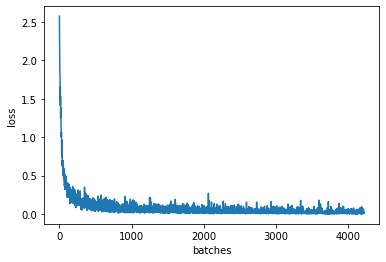

In [ ]:
# plot graph of loss against batches while model is training 
import matplotlib.pyplot as plt 
batch_losses_val_y = [] 
for ele in batch_losses: 
  ele.cpu() 
  batch_losses_val_y.append(ele.item()) 
plt.plot(batch_losses_val_y) 
plt.xlabel("batches") 
plt.ylabel("loss")

#### Feeding Validation data into Trained Model 

In [ ]:
def test_function(test_data, trained_model, loss_function): 
  predicted = [] 
  actual = [] 
  for count, (input_data, labels) in enumerate(val_data): 
    input_data = input_data.cuda() 
    input_data = torch.unsqueeze(input_data, 0)
    y_pred = trained_model(input_data) 
    y = y_pred.tolist() 
    actual.append(labels)
    for i in y: 
      predicted.append(i.index(max(i)))
  return predicted, actual 

In [ ]:
test_data = testset
predicted_val, actual_val = test_function(test_data, trained_model, loss_function)
print(predicted_val) 
print(actual_val)

[9, 9, 8, 9, 1, 6, 2, 7, 3, 8, 7, 5, 6, 4, 9, 2, 7, 1, 7, 2, 8, 3, 1, 1, 9, 7, 3, 1, 3, 8, 9, 3, 8, 9, 5, 1, 4, 1, 5, 5, 2, 2, 3, 0, 9, 0, 5, 1, 0, 2, 6, 8, 7, 6, 3, 3, 1, 3, 1, 3, 5, 8, 2, 4, 0, 4, 7, 8, 6, 7, 5, 1, 8, 2, 1, 4, 1, 9, 4, 0, 9, 1, 1, 4, 3, 7, 7, 7, 0, 1, 4, 7, 1, 8, 8, 5, 5, 9, 5, 3, 0, 3, 7, 2, 1, 8, 2, 5, 7, 8, 3, 9, 1, 5, 7, 9, 7, 5, 7, 0, 0, 6, 4, 6, 8, 2, 8, 9, 2, 6, 0, 4, 0, 9, 8, 8, 3, 5, 6, 7, 1, 1, 2, 7, 3, 5, 8, 4, 3, 9, 1, 9, 2, 0, 9, 8, 1, 7, 3, 9, 3, 3, 9, 9, 3, 0, 4, 9, 6, 3, 5, 4, 1, 0, 7, 1, 9, 9, 9, 8, 3, 9, 7, 1, 3, 4, 2, 8, 0, 5, 9, 2, 6, 2, 3, 2, 0, 2, 6, 0, 5, 5, 2, 2, 7, 0, 0, 2, 9, 3, 2, 5, 5, 9, 4, 6, 5, 2, 2, 8, 6, 4, 4, 3, 0, 5, 7, 9, 6, 2, 8, 3, 9, 1, 9, 5, 1, 0, 8, 0, 7, 8, 0, 3, 2, 8, 2, 3, 5, 7, 3, 5, 5, 9, 1, 7, 2, 9, 5, 5, 0, 1, 6, 1, 9, 9, 1, 1, 0, 5, 0, 9, 6, 1, 8, 6, 7, 5, 2, 5, 3, 0, 0, 6, 0, 5, 6, 8, 1, 1, 7, 0, 2, 9, 3, 8, 9, 1, 8, 4, 7, 3, 1, 9, 0, 4, 3, 9, 6, 7, 3, 3, 2, 1, 7, 8, 8, 2, 6, 6, 9, 9, 2, 0, 5, 3, 2, 8, 3, 0, 9, 6, 4, 

In [ ]:
def accuracy(predicted_labels, true_labels): 
  correct = 0 
  for idx in range(len(predicted_labels)): 
    if predicted_labels[idx] == true_labels[idx]: 
      correct += 1 
  accuracyVal = correct / len(true_labels) * 100 
  return accuracyVal
accuracyVal = accuracy(predicted_val, actual_val) 
print(accuracyVal) 

93.53333333333333
